In [49]:
## analyse the data
import mne
import numpy as np
import matplotlib.pyplot as plt
import glob

from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [50]:
raw=mne.io.read_raw_gdf('BCICIV_2a_gdf/A01E.gdf',
                         eog=['EOG-left', 'EOG-central', 'EOG-right'])
raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])

Extracting EDF parameters from D:\bci project\BCI PROJECT-20220624T090242Z-001\BCI PROJECT\Notebooks\BCI 4\BCICIV_2a_gdf\A01E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...


c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\mne\io\edf\edf.py:1155: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
c:\users\hp\appdata\local\programs\python\python39\lib\contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


<RawGDF | A01E.gdf, 22 x 687000 (2748.0 s), ~26 kB, data not loaded>

From the paper:-
'1023': 1 (Rejected trial),
'1072': 2 (Eye movements),
'276': 3 (eyes open)),
'277': 4 (eyes closed),
'32766':5 (Start of a new run),
'768': 6 (Start of a trial),
'769': 7 (class 1),
'770': 8 (class 2),
'771': 9 (class 3),
'772': 10 (class 4)
event ids are not same for all subjects

In [51]:
 def read_data(path):
    raw=mne.io.read_raw_gdf(path,preload=True,
                          eog=['EOG-left', 'EOG-central', 'EOG-right'])
    raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])
    raw.set_eeg_reference()
    events, event_id =mne.events_from_annotations(raw)
    #events[1]['769'],events[1]['770'],events[1]['771'],events[1]['772']
    ann = event_id.keys()
    ann = list(map(int,ann))
    ids = event_id.values()
    ids = list(ids)
    unq = np.unique(events[:,-1])
    for u in unq:
        events[:,-1] = np.where(events[:,-1]== u , ann[u-1],events[:,-1])
    epochs = mne.Epochs(raw, events, event_id=[770,771],
                        tmin= 0, tmax=4,baseline=(None,4), on_missing ='warn')
    labels=epochs.events[:,-1]
    features=epochs.get_data()
    return features,labels

In [52]:
paths = glob.glob('BCICIV_2a_gdf/*T.gdf')
paths

['BCICIV_2a_gdf\\A01T.gdf',
 'BCICIV_2a_gdf\\A02T.gdf',
 'BCICIV_2a_gdf\\A03T.gdf',
 'BCICIV_2a_gdf\\A04T.gdf',
 'BCICIV_2a_gdf\\A05T.gdf',
 'BCICIV_2a_gdf\\A06T.gdf',
 'BCICIV_2a_gdf\\A07T.gdf',
 'BCICIV_2a_gdf\\A08T.gdf',
 'BCICIV_2a_gdf\\A09T.gdf']

In [53]:
%%capture
features,labels,groups=[],[],[]
for i in paths:
    feature,label=read_data(i)
    features.append(feature)
    labels.append(label)
    groups.append([i]*len(label))

In [54]:
features=np.concatenate(features)
labels=np.concatenate(labels)
groups=np.concatenate(groups)

features.shape,labels.shape,groups.shape

((1296, 22, 1001), (1296,), (1296,))

In [55]:
unique, counts = np.unique(groups, return_counts=True)
unique, counts

(array(['BCICIV_2a_gdf\\A01T.gdf', 'BCICIV_2a_gdf\\A02T.gdf',
        'BCICIV_2a_gdf\\A03T.gdf', 'BCICIV_2a_gdf\\A04T.gdf',
        'BCICIV_2a_gdf\\A05T.gdf', 'BCICIV_2a_gdf\\A06T.gdf',
        'BCICIV_2a_gdf\\A07T.gdf', 'BCICIV_2a_gdf\\A08T.gdf',
        'BCICIV_2a_gdf\\A09T.gdf'], dtype='<U22'),
 array([144, 144, 144, 144, 144, 144, 144, 144, 144], dtype=int64))

# Chronet tensor preparation

In [56]:
from sklearn.model_selection import GroupKFold,LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
gkf=GroupKFold()
from sklearn.base import TransformerMixin,BaseEstimator
from sklearn.preprocessing import StandardScaler
#https://stackoverflow.com/questions/50125844/how-to-standard-scale-a-3d-matrix
class StandardScaler3D(BaseEstimator,TransformerMixin):
    #batch, sequence, channels
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self,X,y=None):
        self.scaler.fit(X.reshape(-1, X.shape[2]))
        return self

    def transform(self,X):
        return self.scaler.transform(X.reshape( -1,X.shape[2])).reshape(X.shape)

In [57]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [58]:
lb = preprocessing.LabelBinarizer()

#enc_df= enc.fit_transform(dataset['60'])
labels =  lb.fit_transform(labels)

In [59]:
np.unique(labels)

array([0, 1])

In [60]:
data_array = features
label_array = labels
group_array = groups
data_array=np.moveaxis(data_array,1,2)

In [61]:
accuracy=[]
for train_index, val_index in gkf.split(data_array, label_array, groups=group_array):
    train_features,train_labels=data_array[train_index],label_array[train_index]
    val_features,val_labels=data_array[val_index],label_array[val_index]
    scaler=StandardScaler3D()
    train_features=scaler.fit_transform(train_features)
    val_features=scaler.transform(val_features)
    break

In [77]:
scaler=StandardScaler3D()
train_features,val_features,train_labels,val_labels = train_test_split(data_array, label_array, test_size=0.2, random_state=2)
train_features=scaler.fit_transform(train_features)
val_features=scaler.transform(val_features)

In [78]:
train_features.shape, train_labels.shape

((1036, 1001, 22), (1036, 1))

In [79]:
train_features=np.moveaxis(train_features,1,2)
val_features=np.moveaxis(val_features,1,2)

In [80]:
train_features.shape, train_labels.shape

((1036, 22, 1001), (1036, 1))

# ShallowConvNet

In [81]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
import tensorflow as tf

In [82]:
def square(x):
    return K.square(x)

def log(x):
    return K.log(K.clip(x, min_value = 1e-7, max_value = 10000))   


def ShallowConvNet(nb_classes, Chans = 64, Samples = 128, dropoutRate = 0.5):
    """ Keras implementation of the Shallow Convolutional Network as described
    in Schirrmeister et. al. (2017), Human Brain Mapping.
    
    Assumes the input is a 2-second EEG signal sampled at 128Hz. Note that in 
    the original paper, they do temporal convolutions of length 25 for EEG
    data sampled at 250Hz. We instead use length 13 since the sampling rate is 
    roughly half of the 250Hz which the paper used. The pool_size and stride
    in later layers is also approximately half of what is used in the paper.
    
    Note that we use the max_norm constraint on all convolutional layers, as 
    well as the classification layer. We also change the defaults for the
    BatchNormalization layer. We used this based on a personal communication 
    with the original authors.
    
                     ours        original paper
    pool_size        1, 35       1, 75
    strides          1, 7        1, 15
    conv filters     1, 13       1, 25    
    
    Note that this implementation has not been verified by the original 
    authors. We do note that this implementation reproduces the results in the
    original paper with minor deviations. 
    """

    # start the model
    input_main   = Input((Chans, Samples, 1))
    block1       = Conv2D(40, (1, 13), 
                                 input_shape=(Chans, Samples, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    block1       = Conv2D(40, (Chans, 1), use_bias=False, 
                          kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block1)
    block1       = Activation(square)(block1)
    block1       = AveragePooling2D(pool_size=(1, 35), strides=(1, 7))(block1)
    block1       = Activation(log)(block1)
    block1       = Dropout(dropoutRate)(block1)
    flatten      = Flatten()(block1)
    dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    softmax      = Activation('sigmoid')(dense)
    
    return Model(inputs=input_main, outputs=softmax)

In [83]:
shallowconvnet = ShallowConvNet(1, features.shape[1],features.shape[2],dropoutRate = 0.3)
shallowconvnet.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 22, 1001, 1)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 22, 989, 40)       560       
                                                                 
 conv2d_7 (Conv2D)           (None, 1, 989, 40)        35200     
                                                                 
 batch_normalization_3 (Batc  (None, 1, 989, 40)       160       
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 1, 989, 40)        0         
                                                                 
 average_pooling2d_3 (Averag  (None, 1, 137, 40)       0         
 ePooling2D)                                               

In [84]:
shallowconvnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss = 'binary_crossentropy',metrics=['accuracy'])

In [90]:
shallowconvnet_history = shallowconvnet.fit(train_features, train_labels,epochs=1,batch_size=32,validation_data=(val_features, val_labels))

33/33 [==============================] - 16s 486ms/step - loss: 0.2494 - accuracy: 0.9170 - val_loss: 0.2720 - val_accuracy: 0.9038


In [91]:
shallowconvnet.save("SCN_RF_90.38.h5")

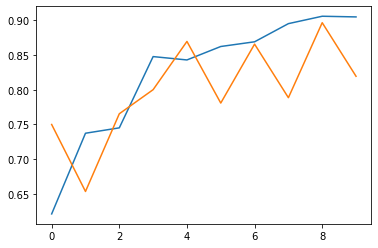

In [46]:
plt.plot(shallowconvnet_history.history["accuracy"])
plt.plot(shallowconvnet_history.history["val_accuracy"])

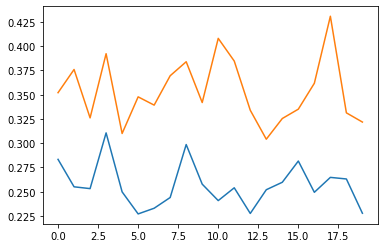

In [32]:
plt.plot(shallowconvnet_history.history["loss"])
plt.plot(shallowconvnet_history.history["val_loss"])

#Binary Class Class accuaracies

In [33]:
model = shallowconvnet

              precision    recall  f1-score   support

           0       0.94      0.91      0.92       481
           1       0.91      0.94      0.93       491

    accuracy                           0.93       972
   macro avg       0.93      0.93      0.93       972
weighted avg       0.93      0.93      0.93       972



<AxesSubplot:>

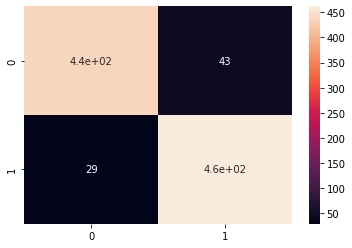

In [34]:
# classification report on training set
y_p = []
pred = model.predict_on_batch(train_features)
pred = pred.reshape(pred.shape[0])
for l in pred:
    if l>0.5:
        y_p.append(1)
    else:
        y_p.append(0)
y_t = train_labels.reshape(train_labels.shape[0])
print(classification_report(y_t, y_p))
cf_matrix = confusion_matrix(y_t, y_p)
sns.heatmap(cf_matrix, annot=True)

              precision    recall  f1-score   support

           0       0.91      0.83      0.87       167
           1       0.84      0.91      0.87       157

    accuracy                           0.87       324
   macro avg       0.87      0.87      0.87       324
weighted avg       0.87      0.87      0.87       324



<AxesSubplot:>

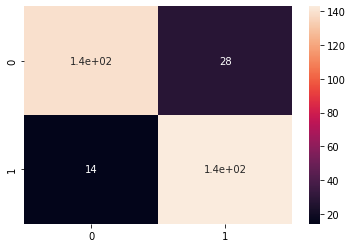

In [35]:
# classification report on validation set
y_p = []
pred = model.predict_on_batch(val_features)
pred = pred.reshape(pred.shape[0])
for l in pred:
    if l>0.5:
        y_p.append(1)
    else:
        y_p.append(0)
y_t = val_labels.reshape(val_labels.shape[0])
print(classification_report(y_t, y_p))
cf_matrix = confusion_matrix(y_t, y_p)
sns.heatmap(cf_matrix, annot=True)

#Multiclass class accuracies 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       324

    accuracy                           1.00       324
   macro avg       1.00      1.00      1.00       324
weighted avg       1.00      1.00      1.00       324



<AxesSubplot:>

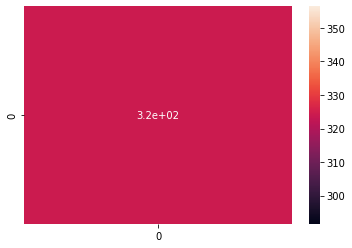

In [36]:
y_t = np.argmax(val_labels, axis=1) # Convert one-hot to index
pred = model.predict_on_batch(val_features)
y_p = np.argmax(pred,axis=1)
print(classification_report(y_t, y_p))
cf_matrix = confusion_matrix(y_t, y_p)
sns.heatmap(cf_matrix, annot=True)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       972

    accuracy                           1.00       972
   macro avg       1.00      1.00      1.00       972
weighted avg       1.00      1.00      1.00       972



<AxesSubplot:>

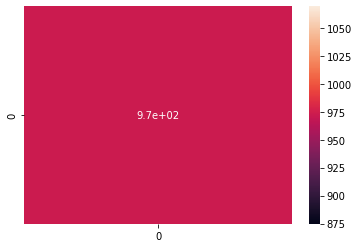

In [37]:
y_t = np.argmax(train_labels, axis=1) # Convert one-hot to index
pred = model.predict_on_batch(train_features)
y_p = np.argmax(pred,axis=1)
print(classification_report(y_t, y_p))
cf_matrix = confusion_matrix(y_t, y_p)
sns.heatmap(cf_matrix, annot=True)

In [38]:
y_p = model.predict_on_batch(val_features)

In [39]:
np.count_nonzero(val_labels)

157

In [40]:
len(val_labels)

324